# Deep Learning &mdash; Assignment 2

Second assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2020_

-----

**Names:**
Enrico Schmitz (s1047521) & Charlotte Cambier van Nooten (s1044122)

**Group:**
Group 22

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Learn how to define and train a neural network with pytorch
2. Experiment with convolutional neural networks
3. Investigate the effect of dropout and batch normalization

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `sounddevice` to play audio,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [ ]:
!pip install torch
!pip install d2l
!pip install python_speech_features

In [2]:
%matplotlib inline
import os
import numpy as np
import d2l
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile
import python_speech_features

## 2.1 Digits dataset

The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**Use `git clone` to download the dataset.**

Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1 or between -1 and 1.

**Update the below code to normalize the data to a reasonable range**

In [61]:
samplerate = 8000
def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
    # Normalize waveform
    waveform_norm = [(n - 0)/(size - 0) for n in waveform]
    #return waveform
    return waveform_norm

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**Load the data into a variable `data`**

In [62]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        #self.y = torch.from_numpy(np.array(digits_y))
        self.y = torch.from_numpy(np.array(digits_y, dtype=np.int64))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Input data
#git clone https://github.com/Jakobovski/free-spoken-digit-dataset
data = SpokenDigits("free-spoken-digit-dataset/recordings/")

In [7]:
# Inside of the data
print(data.x.shape)
print(data.y.shape)
print(len(np.unique(data.y)))

torch.Size([3000, 1, 6000])
torch.Size([3000])
10


**Describe the dataset: how many samples are there, what is their dimensionality? How many classes are there?**

There are 3000 samples, each with 6000 points (variable x). The output of y is 1x3000. In total there are 10 classes.

Here is code to play samples from the dataset to give you an idea what it "looks" like.

In [ ]:
# --> It is not runnable on Deepnote and GoogleCollab
#import sounddevice as sd
#def play(sample):
#    sd.play(sample[0][0], samplerate)
#    print(sample[1])
#play(data[0])

In [63]:
train_prop = 2/3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data)-train_count])

The code above is code to split the data into a training and test set. It uses 2/3 of the data for training.

**Discuss an advantage and disadvantage of using more of the data for training**

Advantage of using more data for training: In most of the situations it is the more data the better. When overfitting the model is learning from fake correlations that are in the training data. So increasing the size of the data shoudl decrease the number of fake correlations, this will lead to an improvement on the performance of the learning part of the model.

Disadvantage of using more data for training: When your added training data is requiring too much computation, the (new) data doesn't give an added value. Also when you model is highly overfitted your model is exactly learning the training data, so when adding new data your model is not generalizing anymore.

Finally, we split the data into batches:

In [64]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter  = torch.utils.data.DataLoader(test,  **data_params)

## 2.2 One dimensional convolutional neural network

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**Complete the network architecture, look at the d2l book chapters 6 and 7 for examples**

In [65]:
net = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    # Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

In [11]:
# Number of parameters
layers_data = torch.randn(size=(3000,1,6000), dtype=torch.float32)
for layer in net:
    layers_data = layer(layers_data)
    print(layer.__class__.__name__,'output shape: \t',layers_data.shape)

Conv1d output shape: 	 torch.Size([3000, 4, 5996])
ReLU output shape: 	 torch.Size([3000, 4, 5996])
AvgPool1d output shape: 	 torch.Size([3000, 4, 2998])
Conv1d output shape: 	 torch.Size([3000, 8, 2994])
ReLU output shape: 	 torch.Size([3000, 8, 2994])
AvgPool1d output shape: 	 torch.Size([3000, 8, 1497])
Conv1d output shape: 	 torch.Size([3000, 16, 1493])
ReLU output shape: 	 torch.Size([3000, 16, 1493])
AvgPool1d output shape: 	 torch.Size([3000, 16, 746])
Conv1d output shape: 	 torch.Size([3000, 32, 742])
ReLU output shape: 	 torch.Size([3000, 32, 742])
AvgPool1d output shape: 	 torch.Size([3000, 32, 371])
Flatten output shape: 	 torch.Size([3000, 11872])
Linear output shape: 	 torch.Size([3000, 128])
ReLU output shape: 	 torch.Size([3000, 128])
Linear output shape: 	 torch.Size([3000, 64])
ReLU output shape: 	 torch.Size([3000, 64])
Linear output shape: 	 torch.Size([3000, 10])


**The first fully connected layer has input dimension 11872, where does that number come from?**

When creating the first fully connected layer, the input comes from the output of the flattend layer. The flatten output layer had an input size of 3000 and an output size of 32*371 coming from the ouput of the pooled layer.

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.

**How many parameters are there in the model? I.e. the total number of weights and biases**

In [ ]:
# Compute the number of parameters
print("Parameters: ",sum([param.nelement() for param in net.parameters()]))

Parameters:  1532090


**Suppose that instead of using convolutions, we had used only fully connected layers. How many parameters would be needed in that case approximately?**

In [73]:
# Number neurons
layers_data = torch.randn(size=(3000,1,6000), dtype=torch.float32)
neurons = 0
previous_neurons = 0
current_neurons = 0
total_neurons = 0
i = 0
for layer in net:
    layers_data = layer(layers_data)
    if layer.__class__.__name__ == 'Conv1d' : 
      current_neurons = (layers_data.shape[0]*layers_data.shape[1]*layers_data.shape[2])
      if i==0:
        previous_neurons = current_neurons
        i+=1
      else :
        total_neurons += ((previous_neurons*current_neurons)+1*current_neurons)
        previous_neurons = current_neurons
print(total_neurons)
    

15424441558752000


We need 15424441558752000 parameters with use of fully connected layers. 


The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to chapter 6.6 and 7.1 of the book.

**How many epochs do you think are needed?**

In [ ]:
print("Size train: ", train_count)

Size train:  2000


In [12]:
lr, num_epochs = 0.01, 25 # Change

We will use the code from the d2l book to train the network.
In particular, the `train_ch6` function, defined in [chapter 6.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is available in the `d2l` library.
However, this function has a bug: it only initializes the weights for 2d convolutional layers, not for 1d convolutional layers.

**Make a copy of the train_ch6 function, and correct the error**

In [12]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [13]:
def train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**Now train the network.**

loss 2.273, train acc 0.163, test acc 0.155
4528.4 examples/sec on cuda:0


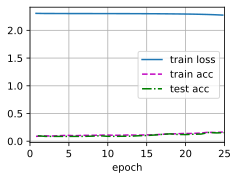

In [15]:
train(net, train_iter, test_iter, num_epochs, lr) #lr and num_epochs as specified above

loss 0.001, train acc 1.000, test acc 0.550
4599.6 examples/sec on cuda:0


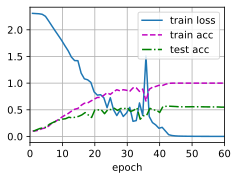

In [16]:
lr, num_epochs = 0.0450, 60 # Change

train(net, train_iter, test_iter, num_epochs, lr)

loss 0.279, train acc 0.914, test acc 0.513
4603.3 examples/sec on cuda:0


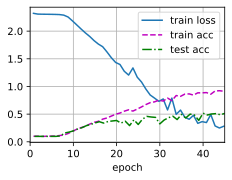

In [17]:
lr, num_epochs = 0.0450, 45 # Change

train(net, train_iter, test_iter, num_epochs, lr)

**Is the training converged?**

If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.

When the changing the learning to a value higher than around 0.5, the number of high spikes increases. When choosing a lower learning rate, the loss is too high. Decreasing the number of epochs (below 40) will give a training that is not converted. A increasing of epochs is not necessary, gives no added value.

## 2.3 Questions and evaluation

**Does the network look like it is overfitting or underfitting?**

Network looks like it is overfitting, train accuracy is higher then the test accuracy (around 20% difference).

**Is what we have here a good classifier? Could it be used in a realistic application?**

No, due to overfitting and a low score for testing.

**Do you think there is enough training data compared to the dimensions of the data and the number of parameters?**

We are not sure if the amount of data satisfies our expectations. We don't know if the overfitting is an consequence of the amount of data or the architecture of the model. 
Maybe with the use of cross validation, improvement can be made. 

**How could the classifier be improved?**

With the use of cross-validation and adding dropout layers. 

**The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing the voice of a new speaker? And if not, how could that be tested instead?**

In [ ]:
# Play audio samples (due to function above not working)
from IPython.display import Audio
Audio(data=data[7][0], rate=samplerate)

This depends on how the data is distributed, when the train data has only a small part of the number of speakers or if every speaker has its own 'number'. When this is the case, the model is able to recognize the tone of the speaker instead of the number. 

## 2.4 Variations

One way in which the training might be improved is with dropout or with batch normalization.

**Make a copy of the network architecture below, and add dropout**

Hint: see [chapter 7.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

In [30]:
net_dropout = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, 10))

loss 0.688, train acc 0.758, test acc 0.689
4477.8 examples/sec on cuda:0


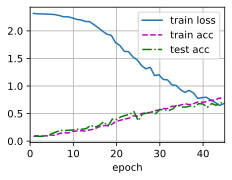

In [31]:
lr, num_epochs = 0.0450, 45 # Same as ended last time

train(net_dropout, train_iter, test_iter, num_epochs, lr)

loss 0.376, train acc 0.876, test acc 0.780
4484.7 examples/sec on cuda:0


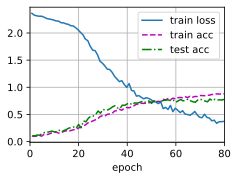

In [32]:
lr, num_epochs = 0.045, 80 # Change

train(net_dropout, train_iter, test_iter, num_epochs, lr)

loss 0.205, train acc 0.939, test acc 0.722
4493.0 examples/sec on cuda:0


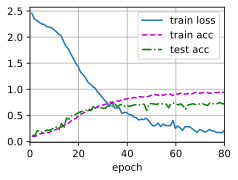

In [33]:
lr, num_epochs = 0.055, 80 # Change

train(net_dropout, train_iter, test_iter, num_epochs, lr)

**How does dropout change the results?**

Using dropout, there is less overfitting, model is more robust. With a higher learning rate, the model is a little bit more overfitting but the loss is lower. 

**Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.**

Hint: see [chapter 7.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

In [38]:
net_batchnorm = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.BatchNorm1d(4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(4, 8, kernel_size=5), nn.BatchNorm1d(8), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.BatchNorm1d(16), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.BatchNorm1d(32), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(11872, 128), nn.BatchNorm1d(128), nn.ReLU(),
    nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 10))

loss 0.012, train acc 1.000, test acc 0.782
3471.4 examples/sec on cuda:0


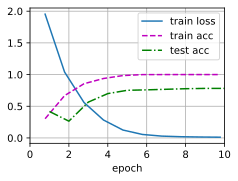

In [42]:
lr, num_epochs = 0.045, 10 # Change
train(net_batchnorm, train_iter, test_iter, num_epochs, lr)

**How does batch normalization change the results?**

When using batch normalization, the number of epochs needed decreases significantly. There is less overfitting.

## 2.5 Bonus: feature extraction

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necesary to do manual feature extraction. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [3]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**Implement a variation of the dataset that uses these features**

In [4]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform_mfcc(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.y = torch.from_numpy(np.array(digits_y, dtype=np.int64))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
data_mfcc = SpokenDigitsMFCC("free-spoken-digit-dataset/recordings/")

train_prop = 2/3
data_params = {'batch_size': 32}

train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data_mfcc, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc  = torch.utils.data.DataLoader(test_mfcc,  **data_params)

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**Inspect the shape of the data, and define a new network architecture that accepts data with this shape**

In [52]:
print(data_mfcc.x.shape)

torch.Size([3000, 13, 74])


In [57]:
net_MFCC = torch.nn.Sequential(
    nn.Conv1d(13, 26, kernel_size=4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(26, 52, kernel_size=4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(52, 104, kernel_size=4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(104, 208, kernel_size=4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(208, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

In [58]:
layers_data = torch.randn(size=(3000,13,74), dtype=torch.float32)
for layer in net_MFCC:
    layers_data = layer(layers_data)
    print(layer.__class__.__name__,'output shape: \t',layers_data.shape)

Conv1d output shape: 	 torch.Size([3000, 26, 71])
ReLU output shape: 	 torch.Size([3000, 26, 71])
AvgPool1d output shape: 	 torch.Size([3000, 26, 35])
Conv1d output shape: 	 torch.Size([3000, 52, 32])
ReLU output shape: 	 torch.Size([3000, 52, 32])
AvgPool1d output shape: 	 torch.Size([3000, 52, 16])
Conv1d output shape: 	 torch.Size([3000, 104, 13])
ReLU output shape: 	 torch.Size([3000, 104, 13])
AvgPool1d output shape: 	 torch.Size([3000, 104, 6])
Conv1d output shape: 	 torch.Size([3000, 208, 3])
ReLU output shape: 	 torch.Size([3000, 208, 3])
AvgPool1d output shape: 	 torch.Size([3000, 208, 1])
Flatten output shape: 	 torch.Size([3000, 208])
Linear output shape: 	 torch.Size([3000, 128])
ReLU output shape: 	 torch.Size([3000, 128])
Linear output shape: 	 torch.Size([3000, 64])
ReLU output shape: 	 torch.Size([3000, 64])
Linear output shape: 	 torch.Size([3000, 10])


**Train the network with the mfcc features.**

loss 0.000, train acc 1.000, test acc 0.975
7011.7 examples/sec on cuda:0


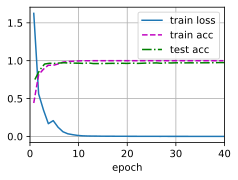

In [60]:
lr, num_epochs = 0.04, 40 # Same as ended in original
train(net_MFCC, train_iter_mfcc, test_iter_mfcc, num_epochs, lr)

**Is there a neural-network based alternative to mfcc features?**

Using the mfcc is not best when looking at noise, mfcc features gives not very robust model for the added noise. Instead, use can be made to supress the noise (integrated in the model).

## The end

Well done! Please double check the instructions at the top before you submit your results.